# Product Classification using Graph Features

This notebook focuses on extracting features from the product graph to predict product classes. We'll use the graph structure to extract meaningful features that can help in classifying products into their respective categories.


## Install Required Libraries


In [1]:
# Install required packages if not already installed
# !pip install networkx matplotlib pandas scikit-learn numpy plotly xgboost node2vec tensorflow karateclub

## Import Libraries


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import XGBoost
import xgboost as xgb

# Import TensorFlow for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import node2vec
from karateclub import DeepWalk


2025-05-10 14:41:15.703443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746877275.764299   11466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746877275.783212   11466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 14:41:15.929340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data


In [2]:
# Load the edge list data
edgelist_file = 'data_files/edgelist.txt'
edges_df = pd.read_csv(edgelist_file, header=None, names=['source', 'target'])

# Load the class labels
labels_file = 'y_train.txt'
labels_df = pd.read_csv(labels_file, header=None, names=['product_id', 'label'])

# Load the train and test splits
train_df = pd.read_csv('split_dataset/train.csv')
test_df = pd.read_csv('split_dataset/test.csv')

# Display basic information about the datasets
print(f"Edge list shape: {edges_df.shape}")
print(f"Labels shape: {labels_df.shape}")
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Check the first few rows of each dataset
print("\nEdge list sample:")
print(edges_df.head())

print("\nLabels sample:")
print(labels_df.head())

print("\nTrain set sample:")
print(train_df.head())

print("\nTest set sample:")
print(test_df.head())


Edge list shape: (1811087, 2)
Labels shape: (182006, 2)
Train set shape: (145604, 3)
Test set shape: (36402, 3)

Edge list sample:
   source  target
0  251528  237411
1  100805   74791
2   38634   97747
3  247470   77089
4  267060  250490

Labels sample:
   product_id  label
0       66795      9
1      242781      3
2       91280      2
3       56356      5
4      218494      0

Train set sample:
   product_id                                         text_clean  label
0      114704  hornady unprimed winchester cartridge case hor...      2
1      250731  tachikara tk leopard knee pad tachikara tk leo...     11
2      152967  g asd replacement cutter aluminum amp carbon u...      2
3        4541  mtech usa mt tactical folding knife inch close...      2
4      142062  nhl pittsburgh penguins game day black pro sha...      7

Test set sample:
   product_id                                         text_clean  label
0       56218                             katz hoodie volleyball      0
1     

## Create Graph from Edge List


In [3]:
# Create a graph from the edge list
G = nx.from_pandas_edgelist(edges_df, 'source', 'target')

# Print basic information about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network Density: {nx.density(G):.6f}")

# Check if the graph is connected
is_connected = nx.is_connected(G)
print(f"Is the graph connected? {is_connected}")

if not is_connected:
    # Get the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    largest_cc_subgraph = G.subgraph(largest_cc)
    print(f"\nLargest Connected Component:")
    print(f"  Nodes: {largest_cc_subgraph.number_of_nodes()}")
    print(f"  Edges: {largest_cc_subgraph.number_of_edges()}")
    print(f"  Percentage of total nodes: {largest_cc_subgraph.number_of_nodes() / G.number_of_nodes() * 100:.2f}%")


Number of nodes: 276453
Number of edges: 1811087
Network Density: 0.000047
Is the graph connected? False

Largest Connected Component:
  Nodes: 273012
  Edges: 1808230
  Percentage of total nodes: 98.76%


## Extract Graph Features

We'll extract the following features for each product (node) in the graph:
1. Degree Centrality: Number of connections a node has
2. Clustering Coefficient: Measure of how nodes tend to cluster together
3. PageRank: Importance of a node based on the structure of incoming links
4. Betweenness Centrality: Measure of node's centrality in a graph based on shortest paths
5. Closeness Centrality: Measure of how close a node is to all other nodes
6. Eigenvector Centrality: Measure of the influence of a node in a network
7. Triangle Count: Number of triangles a node is part of


In [4]:
# Function to extract graph features for a set of nodes
def extract_graph_features(G, node_list):
    print("Calculating degree centrality...")
    degree_centrality = nx.degree_centrality(G)

    print("Calculating clustering coefficient...")
    clustering_coefficient = nx.clustering(G)

    print("Calculating PageRank...")
    pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)

    # For large graphs, betweenness and closeness centrality can be computationally expensive
    # We'll use approximation methods or limit to a subset of nodes if needed

    print("Calculating triangle count...")
    triangles = nx.triangles(G)

    # Create a dataframe with the features
    features_df = pd.DataFrame(index=node_list)

    features_df['degree_centrality'] = features_df.index.map(lambda x: degree_centrality.get(x, 0))
    features_df['clustering_coefficient'] = features_df.index.map(lambda x: clustering_coefficient.get(x, 0))
    features_df['pagerank'] = features_df.index.map(lambda x: pagerank.get(x, 0))
    features_df['triangle_count'] = features_df.index.map(lambda x: triangles.get(x, 0))


    # Degree (number of connections)
    print("Calculating degree...")
    degree_dict = dict(G.degree())
    features_df['degree'] = features_df.index.map(lambda x: degree_dict.get(x, 0))

    # For a subset of nodes, calculate betweenness centrality
    # This is computationally expensive, so we'll use a sample if the graph is large
    # if len(node_list) < 5000:
    #     print("Calculating betweenness centrality...")
    #     betweenness_centrality = nx.betweenness_centrality(G, k=min(500, len(G.nodes())), normalized=True)
    #     features_df['betweenness_centrality'] = features_df.index.map(lambda x: betweenness_centrality.get(x, 0))
    # else:
    #     print("Skipping betweenness centrality due to graph size...")
    #     features_df['betweenness_centrality'] = 0
    #
    # # For a subset of nodes, calculate closeness centrality
    # if len(node_list) < 5000:
    #     print("Calculating closeness centrality...")
    #     closeness_centrality = nx.closeness_centrality(G)
    #     features_df['closeness_centrality'] = features_df.index.map(lambda x: closeness_centrality.get(x, 0))
    # else:
    #     print("Skipping closeness centrality due to graph size...")
    #     features_df['closeness_centrality'] = 0
    #
    # # Calculate eigenvector centrality
    # try:
    #     print("Calculating eigenvector centrality...")
    #     eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=100)
    #     features_df['eigenvector_centrality'] = features_df.index.map(lambda x: eigenvector_centrality.get(x, 0))
    # except:
    #     print("Eigenvector centrality calculation failed, using approximation...")
    #     features_df['eigenvector_centrality'] = 0

    return features_df


## Prepare Training and Testing Data


In [5]:
# Get the list of product IDs from train and test sets
train_product_ids = train_df['product_id'].tolist()
test_product_ids = test_df['product_id'].tolist()

# Extract features for training and testing sets
print("Extracting features for training set...")
train_features = extract_graph_features(G, train_product_ids)

print("\nExtracting features for testing set...")
test_features = extract_graph_features(G, test_product_ids)

# Get the labels for training and testing sets
train_labels = train_df['label'].values
test_labels = test_df['label'].values

# Display the feature dataframes
print("\nTraining features shape:", train_features.shape)
print("Testing features shape:", test_features.shape)

# Check for missing values
print("\nMissing values in training features:", train_features.isnull().sum().sum())
print("Missing values in testing features:", test_features.isnull().sum().sum())

# Fill missing values with 0 if any
train_features = train_features.fillna(0)
test_features = test_features.fillna(0)

# Scale the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)


Extracting features for training set...
Calculating degree centrality...
Calculating clustering coefficient...
Calculating PageRank...
Calculating triangle count...
Calculating degree...

Extracting features for testing set...
Calculating degree centrality...
Calculating clustering coefficient...
Calculating PageRank...
Calculating triangle count...
Calculating degree...

Training features shape: (145604, 5)
Testing features shape: (36402, 5)

Missing values in training features: 0
Missing values in testing features: 0


## Train and Evaluate Models


### Random Forest Classifier


In [6]:
# Train a Random Forest classifier
print("Training Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(train_features_scaled, train_labels)

# Make predictions on the test set
rf_test_pred = rf_model.predict(test_features_scaled)
rf_test_pred_proba = rf_model.predict_proba(test_features_scaled)

# Calculate accuracy
rf_accuracy = accuracy_score(test_labels, rf_test_pred)
print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")

# Calculate multi-class log loss
rf_loss = log_loss(test_labels, rf_test_pred_proba)
print(f"Random Forest Multi-class Log Loss: {rf_loss:.4f}")

# Print classification report
print("\nRandom Forest Classification Report:")
print(classification_report(test_labels, rf_test_pred))


Training Random Forest classifier...
Random Forest Test Accuracy: 0.2677
Random Forest Multi-class Log Loss: 12.4784

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      3033
           1       0.12      0.12      0.12      2372
           2       0.38      0.39      0.38      8652
           3       0.15      0.15      0.15      1073
           4       0.19      0.19      0.19      3016
           5       0.16      0.15      0.15      3565
           6       0.09      0.08      0.09      1519
           7       0.47      0.48      0.47      3752
           8       0.08      0.07      0.07      1316
           9       0.11      0.11      0.11       903
          10       0.16      0.16      0.16      3589
          11       0.20      0.19      0.20      1425
          12       0.15      0.13      0.14      1318
          13       0.22      0.21      0.22       323
          14       0.05      0.04 

### Logistic Regression


In [7]:
# Train a Logistic Regression classifier
print("Training Logistic Regression classifier...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(train_features_scaled, train_labels)

# Make predictions on the test set
lr_test_pred = lr_model.predict(test_features_scaled)
lr_test_pred_proba = lr_model.predict_proba(test_features_scaled)

# Calculate accuracy
lr_accuracy = accuracy_score(test_labels, lr_test_pred)
print(f"Logistic Regression Test Accuracy: {lr_accuracy:.4f}")

# Calculate multi-class log loss
lr_loss = log_loss(test_labels, lr_test_pred_proba)
print(f"Logistic Regression Multi-class Log Loss: {lr_loss:.4f}")

# Print classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(test_labels, lr_test_pred))


Training Logistic Regression classifier...
Logistic Regression Test Accuracy: 0.3144
Logistic Regression Multi-class Log Loss: 2.2013

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.37      0.32      3033
           1       0.00      0.00      0.00      2372
           2       0.31      0.91      0.46      8652
           3       0.50      0.00      0.00      1073
           4       0.15      0.05      0.07      3016
           5       0.17      0.00      0.01      3565
           6       0.00      0.00      0.00      1519
           7       0.39      0.59      0.47      3752
           8       0.00      0.00      0.00      1316
           9       0.00      0.00      0.00       903
          10       0.22      0.02      0.04      3589
          11       0.33      0.00      0.00      1425
          12       0.33      0.00      0.00      1318
          13       0.00      0.00      0.00       323
          1

### Support Vector Machine (SVM)


Takes too long to run (45m)

In [9]:
# # Train an SVM classifier
# print("Training SVM classifier...")
# # Using a linear kernel for faster training
# svm_model = SVC(kernel='linear', probability=True, random_state=42)
# svm_model.fit(train_features_scaled, train_labels)
#
# # Make predictions on the test set
# svm_test_pred = svm_model.predict(test_features_scaled)
# svm_test_pred_proba = svm_model.predict_proba(test_features_scaled)
#
# # Calculate accuracy
# svm_accuracy = accuracy_score(test_labels, svm_test_pred)
# print(f"SVM Test Accuracy: {svm_accuracy:.4f}")
#
# # Calculate multi-class log loss
# svm_loss = log_loss(test_labels, svm_test_pred_proba)
# print(f"SVM Multi-class Log Loss: {svm_loss:.4f}")
#
# # Print classification report
# print("\nSVM Classification Report:")
# print(classification_report(test_labels, svm_test_pred))


Training SVM classifier...
SVM Test Accuracy: 0.3159
SVM Multi-class Log Loss: 2.1890

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.43      0.33      3033
           1       0.00      0.00      0.00      2372
           2       0.31      0.92      0.46      8652
           3       0.00      0.00      0.00      1073
           4       0.67      0.00      0.00      3016
           5       0.00      0.00      0.00      3565
           6       0.00      0.00      0.00      1519
           7       0.39      0.59      0.47      3752
           8       0.00      0.00      0.00      1316
           9       0.00      0.00      0.00       903
          10       0.00      0.00      0.00      3589
          11       0.00      0.00      0.00      1425
          12       0.00      0.00      0.00      1318
          13       0.00      0.00      0.00       323
          14       0.00      0.00      0.00       226
          15       0.

### XGBoost

In [8]:
# Train an XGBoost classifier
print("Training XGBoost classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(train_features_scaled, train_labels)

# Make predictions on the test set
xgb_test_pred = xgb_model.predict(test_features_scaled)
xgb_test_pred_proba = xgb_model.predict_proba(test_features_scaled)

# Calculate accuracy
xgb_accuracy = accuracy_score(test_labels, xgb_test_pred)
print(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}")

# Calculate multi-class log loss
xgb_loss = log_loss(test_labels, xgb_test_pred_proba)
print(f"XGBoost Multi-class Log Loss: {xgb_loss:.4f}")

# Print classification report
print("\nXGBoost Classification Report:")
print(classification_report(test_labels, xgb_test_pred))


Training XGBoost classifier...
XGBoost Test Accuracy: 0.3432
XGBoost Multi-class Log Loss: 2.0553

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.51      0.43      3033
           1       0.19      0.02      0.03      2372
           2       0.35      0.83      0.49      8652
           3       0.56      0.01      0.03      1073
           4       0.23      0.08      0.12      3016
           5       0.18      0.07      0.10      3565
           6       0.24      0.00      0.01      1519
           7       0.39      0.72      0.51      3752
           8       0.00      0.00      0.00      1316
           9       0.50      0.00      0.00       903
          10       0.22      0.11      0.15      3589
          11       0.25      0.00      0.01      1425
          12       0.49      0.04      0.08      1318
          13       0.60      0.02      0.04       323
          14       0.00      0.00      0.00       226
     

### Neural Network


Number of classes: 16
Building Neural Network model...
Training Neural Network...
Epoch 1/50


2025-05-05 17:37:35.937878: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


3641/3641 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.2804 - loss: 2.3107 - val_accuracy: 0.3271 - val_loss: 2.1120
Epoch 2/50
3641/3641 ━━━━━━━━━━━━━━━━━━━━ 4s 979us/step - accuracy: 0.3244 - loss: 2.1394 - val_accuracy: 0.3326 - val_loss: 2.0901
Epoch 3/50
3641/3641 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3296 - loss: 2.1120 - val_accuracy: 0.3344 - val_loss: 2.0814
Epoch 4/50
3641/3641 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3304 - loss: 2.1041 - val_accuracy: 0.3370 - val_loss: 2.0744
Epoch 5/50
3641/3641 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3307 - loss: 2.1002 - val_accuracy: 0.3346 - val_loss: 2.0737
Epoch 6/50
3641/3641 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3310 - loss: 2.0947 - val_accuracy: 0.3365 - val_loss: 2.0704
Epoch 7/50
3641/3641 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3352 - loss: 2.0895 - val_accuracy: 0.3384 - val_loss: 2.0649
Epoch 8/50
3641/3641 ━━━━━━━━━━━━━━━━━━━━ 4s 993us/step - accuracy: 0.3363 - loss: 2.0848 - val_acc

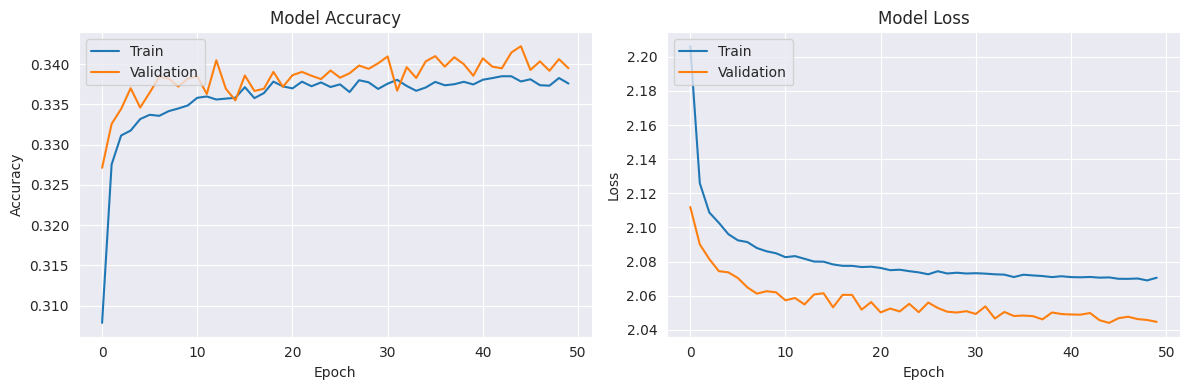

In [12]:
# Define the number of classes
num_classes = len(np.unique(train_labels))
print(f"Number of classes: {num_classes}")

# Convert labels to one-hot encoding for neural network
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

# Build a simple neural network model
print("Building Neural Network model...")
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(train_features_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model
nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
print("Training Neural Network...")
history = nn_model.fit(
    train_features_scaled,
    train_labels_onehot,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
nn_test_pred_proba = nn_model.predict(test_features_scaled)
nn_test_pred = np.argmax(nn_test_pred_proba, axis=1)

# Calculate accuracy
nn_accuracy = accuracy_score(test_labels, nn_test_pred)
print(f"Neural Network Test Accuracy: {nn_accuracy:.4f}")

# Calculate multi-class log loss
nn_loss = log_loss(test_labels, nn_test_pred_proba)
print(f"Neural Network Multi-class Log Loss: {nn_loss:.4f}")

# Print classification report
print("\nNeural Network Classification Report:")
print(classification_report(test_labels, nn_test_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


### Model Comparison


In [ ]:
# Compare the performance of all models
models = ['Random Forest', 'Logistic Regression', 'XGBoost', 'Neural Network']
accuracies = [rf_accuracy, lr_accuracy, xgb_accuracy, nn_accuracy]
losses = [rf_loss, lr_loss, xgb_loss, nn_loss]

# Create a dataframe for comparison
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Log Loss': losses
})

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

# Display the comparison
print("Model Performance Comparison:")
print(comparison_df)

# Plot the comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(comparison_df['Model'], comparison_df['Accuracy'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(comparison_df['Model'], comparison_df['Log Loss'])
plt.title('Model Log Loss Comparison')
plt.ylabel('Log Loss')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Interactive comparison plot with Plotly
fig = go.Figure()
fig.add_trace(go.Bar(x=comparison_df['Model'], y=comparison_df['Accuracy'], name='Accuracy'))
fig.add_trace(go.Bar(x=comparison_df['Model'], y=comparison_df['Log Loss'], name='Log Loss', yaxis='y2'))

fig.update_layout(
    title='Model Performance Comparison',
    yaxis=dict(title='Accuracy', side='left', range=[0, 1]),
    yaxis2=dict(title='Log Loss', side='right', overlaying='y'),
    barmode='group'
)

fig.show()


## Advanced Graph Embeddings

In this section, we'll explore more advanced graph embedding techniques to extract richer features from the graph structure. We'll implement:

1. Node2Vec: A flexible neighborhood sampling strategy that combines BFS and DFS approaches
2. DeepWalk: Uses random walks to learn latent representations of nodes in a graph

These embedding techniques can capture more complex structural information than traditional graph features.


### Node2Vec Embeddings


### DeepWalk Embeddings (LOOK HERE!!!!)


In [6]:
# Generate Node2Vec embeddings
print("Generating Node2Vec embeddings...")

try:
    # Convert NetworkX graph to node2vec format
    # First, ensure all nodes are strings for compatibility
    G_node2vec = nx.Graph()
    for edge in G.edges():
        G_node2vec.add_edge(str(edge[0]), str(edge[1]))

    # Initialize node2vec model
    node2vec_model = node2vec.Node2Vec(
        G_node2vec,
        dimensions=128,  # Embedding dimension
        walk_length=10,  # Length of each random walk
        num_walks=10,    # Number of random walks per node
        workers=1        # Number of parallel workers
    )

    # Train the model
    print("Training Node2Vec model...")
    n2v_model = node2vec_model.fit(
        window=10,       # Context size for optimization
        min_count=1,     # Minimum count of node occurrences
        batch_words=4    # Number of words per batch
    )

    # Generate embeddings for train and test nodes
    train_node2vec_features = np.zeros((len(train_product_ids), 64))
    test_node2vec_features = np.zeros((len(test_product_ids), 64))

    # Extract embeddings for training nodes
    for i, node_id in enumerate(train_product_ids):
        try:
            train_node2vec_features[i] = n2v_model.wv[str(node_id)]
        except KeyError:
            # If node not in embeddings, use zeros
            pass

    # Extract embeddings for testing nodes
    for i, node_id in enumerate(test_product_ids):
        try:
            test_node2vec_features[i] = n2v_model.wv[str(node_id)]
        except KeyError:
            # If node not in embeddings, use zeros
            pass

    print(f"Node2Vec embeddings shape - Train: {train_node2vec_features.shape}, Test: {test_node2vec_features.shape}")

    # Scale the embeddings
    n2v_scaler = StandardScaler()
    train_node2vec_scaled = n2v_scaler.fit_transform(train_node2vec_features)
    test_node2vec_scaled = n2v_scaler.transform(test_node2vec_features)

    # Train a classifier on Node2Vec embeddings
    print("Training XGBoost on Node2Vec embeddings...")
    n2v_xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
    n2v_xgb_model.fit(train_node2vec_scaled, train_labels)

    # Make predictions
    n2v_xgb_test_pred = n2v_xgb_model.predict(test_node2vec_scaled)
    n2v_xgb_test_pred_proba = n2v_xgb_model.predict_proba(test_node2vec_scaled)

    # Calculate metrics
    n2v_xgb_accuracy = accuracy_score(test_labels, n2v_xgb_test_pred)
    n2v_xgb_loss = log_loss(test_labels, n2v_xgb_test_pred_proba)

    print(f"Node2Vec XGBoost Test Accuracy: {n2v_xgb_accuracy:.4f}")
    print(f"Node2Vec XGBoost Multi-class Log Loss: {n2v_xgb_loss:.4f}")
    print("\nNode2Vec XGBoost Classification Report:")
    print(classification_report(test_labels, n2v_xgb_test_pred))

except Exception as e:
    print(f"Error generating Node2Vec embeddings: {e}")
    print("Skipping Node2Vec embeddings...")


Generating Node2Vec embeddings...


Computing transition probabilities:   0%|          | 0/276453 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:41<00:00,  8.22s/it]


Training Node2Vec model...
Node2Vec embeddings shape - Train: (145604, 64), Test: (36402, 64)
Training XGBoost on Node2Vec embeddings...
Node2Vec XGBoost Test Accuracy: 0.8809
Node2Vec XGBoost Multi-class Log Loss: 0.4332

Node2Vec XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3033
           1       0.81      0.78      0.79      2372
           2       0.86      0.94      0.90      8652
           3       0.88      0.93      0.90      1073
           4       0.89      0.92      0.91      3016
           5       0.94      0.95      0.94      3565
           6       0.92      0.87      0.89      1519
           7       0.85      0.81      0.83      3752
           8       0.92      0.91      0.92      1316
           9       0.91      0.89      0.90       903
          10       0.84      0.79      0.81      3589
          11       0.88      0.86      0.87      1425
          12       0.90      0.74 

In [10]:
# Generate DeepWalk embeddings
print("Generating DeepWalk embeddings...")

try:
    # Initialize DeepWalk model
    deepwalk_model = DeepWalk(
        walk_number=10,      # Number of random walks per node
        walk_length=10,      # Length of each random walk
        dimensions=128,       # Embedding dimension
        workers=4            # Number of parallel workers
    )

    # Convert NetworkX graph to a format compatible with karateclub
    # DeepWalk expects node IDs to be consecutive integers starting from 0
    G_deepwalk = nx.Graph()
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    reverse_mapping = {i: node for node, i in node_mapping.items()}

    for edge in G.edges():
        G_deepwalk.add_edge(node_mapping[edge[0]], node_mapping[edge[1]])

    # Fit the model
    print("Training DeepWalk model...")
    deepwalk_model.fit(G_deepwalk)

    # Get embeddings for all nodes
    deepwalk_embeddings = deepwalk_model.get_embedding()

    # Generate embeddings for train and test nodes
    train_deepwalk_features = np.zeros((len(train_product_ids), 64))
    test_deepwalk_features = np.zeros((len(test_product_ids), 64))

    # Extract embeddings for training nodes
    for i, node_id in enumerate(train_product_ids):
        if node_id in node_mapping:
            train_deepwalk_features[i] = deepwalk_embeddings[node_mapping[node_id]]

    # Extract embeddings for testing nodes
    for i, node_id in enumerate(test_product_ids):
        if node_id in node_mapping:
            test_deepwalk_features[i] = deepwalk_embeddings[node_mapping[node_id]]

    print(f"DeepWalk embeddings shape - Train: {train_deepwalk_features.shape}, Test: {test_deepwalk_features.shape}")

    # Scale the embeddings
    dw_scaler = StandardScaler()
    train_deepwalk_scaled = dw_scaler.fit_transform(train_deepwalk_features)
    test_deepwalk_scaled = dw_scaler.transform(test_deepwalk_features)

    # Train a classifier on DeepWalk embeddings
    deepwalk_xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
    deepwalk_xgb_model.fit(train_deepwalk_scaled, train_labels)

    # Make predictions
    deepwalk_xgb_test_pred = n2v_xgb_model.predict(test_deepwalk_scaled)
    deepwalk_xgb_test_pred_proba = n2v_xgb_model.predict_proba(test_deepwalk_scaled)

    # Calculate metrics
    deepewalk_xgb_accuracy = accuracy_score(test_labels, deepwalk_xgb_test_pred)
    deepewalk_xgb_loss = log_loss(test_labels, deepwalk_xgb_test_pred_proba)

    print(f"Deepwalk XGBoost Test Accuracy: {deepewalk_xgb_accuracy:.4f}")
    print(f"Deepwalk XGBoost Multi-class Log Loss: {deepewalk_xgb_loss:.4f}")
    print("\nDeepwalk XGBoost Classification Report:")
    print(classification_report(test_labels, deepwalk_xgb_test_pred))

except Exception as e:
    print(f"Error generating DeepWalk embeddings: {e}")
    print("Skipping DeepWalk embeddings...")


Generating DeepWalk embeddings...
Training DeepWalk model...
DeepWalk embeddings shape - Train: (145604, 64), Test: (36402, 64)
Training Random Forest on DeepWalk embeddings...
DeepWalk Random Forest Test Accuracy: 0.7042
DeepWalk Random Forest Multi-class Log Loss: 1.4060

DeepWalk Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      3033
           1       0.88      0.52      0.66      2372
           2       0.57      0.93      0.71      8652
           3       0.91      0.63      0.74      1073
           4       0.85      0.69      0.76      3016
           5       0.85      0.83      0.84      3565
           6       0.94      0.65      0.77      1519
           7       0.56      0.68      0.61      3752
           8       0.97      0.57      0.72      1316
           9       0.96      0.48      0.64       903
          10       0.82      0.61      0.70      3589
          11       0.92      0

### Combined Features (Traditional + Embeddings)


In [ ]:
# Combine traditional graph features with embeddings for potentially better performance
try:
    print("Combining traditional features with embeddings...")

    # Check if both embedding methods were successful
    embeddings_available = []
    if 'train_node2vec_scaled' in locals():
        embeddings_available.append('Node2Vec')
    if 'train_deepwalk_scaled' in locals():
        embeddings_available.append('DeepWalk')

    print(f"Available embeddings: {embeddings_available}")

    if embeddings_available:
        # Combine with traditional features
        if 'train_node2vec_scaled' in locals():
            # Combine with Node2Vec
            train_combined_n2v = np.hstack((train_features_scaled, train_node2vec_scaled))
            test_combined_n2v = np.hstack((test_features_scaled, test_node2vec_scaled))

            print(f"Combined features with Node2Vec shape - Train: {train_combined_n2v.shape}, Test: {test_combined_n2v.shape}")

            # Train a classifier on combined features
            print("Training XGBoost on combined features with Node2Vec...")
            combined_n2v_xgb_model = xgb.XGBClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                random_state=42,
                n_jobs=-1
            )
            combined_n2v_xgb_model.fit(train_combined_n2v, train_labels)

            # Make predictions
            combined_n2v_xgb_test_pred = combined_n2v_xgb_model.predict(test_combined_n2v)
            combined_n2v_xgb_test_pred_proba = combined_n2v_xgb_model.predict_proba(test_combined_n2v)

            # Calculate metrics
            combined_n2v_xgb_accuracy = accuracy_score(test_labels, combined_n2v_xgb_test_pred)
            combined_n2v_xgb_loss = log_loss(test_labels, combined_n2v_xgb_test_pred_proba)

            print(f"Combined with Node2Vec XGBoost Test Accuracy: {combined_n2v_xgb_accuracy:.4f}")
            print(f"Combined with Node2Vec XGBoost Multi-class Log Loss: {combined_n2v_xgb_loss:.4f}")

        if 'train_deepwalk_scaled' in locals():
            # Combine with DeepWalk
            train_combined_dw = np.hstack((train_features_scaled, train_deepwalk_scaled))
            test_combined_dw = np.hstack((test_features_scaled, test_deepwalk_scaled))

            print(f"Combined features with DeepWalk shape - Train: {train_combined_dw.shape}, Test: {test_combined_dw.shape}")

            # Train a classifier on combined features
            print("Training Random Forest on combined features with DeepWalk...")
            combined_dw_rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            combined_dw_rf_model.fit(train_combined_dw, train_labels)

            # Make predictions
            combined_dw_rf_test_pred = combined_dw_rf_model.predict(test_combined_dw)
            combined_dw_rf_test_pred_proba = combined_dw_rf_model.predict_proba(test_combined_dw)

            # Calculate metrics
            combined_dw_rf_accuracy = accuracy_score(test_labels, combined_dw_rf_test_pred)
            combined_dw_rf_loss = log_loss(test_labels, combined_dw_rf_test_pred_proba)

            print(f"Combined with DeepWalk Random Forest Test Accuracy: {combined_dw_rf_accuracy:.4f}")
            print(f"Combined with DeepWalk Random Forest Multi-class Log Loss: {combined_dw_rf_loss:.4f}")

        # If both embeddings are available, combine all features
        if 'train_node2vec_scaled' in locals() and 'train_deepwalk_scaled' in locals():
            train_combined_all = np.hstack((train_features_scaled, train_node2vec_scaled, train_deepwalk_scaled))
            test_combined_all = np.hstack((test_features_scaled, test_node2vec_scaled, test_deepwalk_scaled))

            print(f"Combined all features shape - Train: {train_combined_all.shape}, Test: {test_combined_all.shape}")

            # Train a classifier on all combined features
            print("Training Random Forest on all combined features...")
            combined_all_rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            combined_all_rf_model.fit(train_combined_all, train_labels)

            # Make predictions
            combined_all_rf_test_pred = combined_all_rf_model.predict(test_combined_all)
            combined_all_rf_test_pred_proba = combined_all_rf_model.predict_proba(test_combined_all)

            # Calculate metrics
            combined_all_rf_accuracy = accuracy_score(test_labels, combined_all_rf_test_pred)
            combined_all_rf_loss = log_loss(test_labels, combined_all_rf_test_pred_proba)

            print(f"Combined All Features Random Forest Test Accuracy: {combined_all_rf_accuracy:.4f}")
            print(f"Combined All Features Random Forest Multi-class Log Loss: {combined_all_rf_loss:.4f}")
    else:
        print("No embeddings available for combination.")

except Exception as e:
    print(f"Error combining features: {e}")
    print("Skipping combined features analysis...")


Combining traditional features with embeddings...
Available embeddings: ['Node2Vec', 'DeepWalk']
Combined features with Node2Vec shape - Train: (145604, 69), Test: (36402, 69)
Training Random Forest on combined features with Node2Vec...
Combined with Node2Vec Random Forest Test Accuracy: 0.9025
Combined with Node2Vec Random Forest Multi-class Log Loss: 0.5452
Combined features with DeepWalk shape - Train: (145604, 69), Test: (36402, 69)
Training Random Forest on combined features with DeepWalk...


### Final Model Comparison


In [ ]:
# Create a comprehensive comparison of all models
try:
    print("Creating final model comparison...")

    # Start with the basic models
    all_models = ['Random Forest', 'Logistic Regression', 'XGBoost', 'Neural Network']
    all_accuracies = [rf_accuracy, lr_accuracy, xgb_accuracy, nn_accuracy]
    all_losses = [rf_loss, lr_loss, xgb_loss, nn_loss]

    # Add embedding-based models if available
    if 'n2v_xgb_accuracy' in locals():
        all_models.append('Node2Vec XGBoost')
        all_accuracies.append(n2v_xgb_accuracy)
        all_losses.append(n2v_xgb_loss)

    if 'dw_rf_accuracy' in locals():
        all_models.append('DeepWalk RF')
        all_accuracies.append(dw_rf_accuracy)
        all_losses.append(dw_rf_loss)

    if 'combined_n2v_xgb_accuracy' in locals():
        all_models.append('Combined Node2Vec XGBoost')
        all_accuracies.append(combined_n2v_xgb_accuracy)
        all_losses.append(combined_n2v_xgb_loss)

    if 'combined_dw_rf_accuracy' in locals():
        all_models.append('Combined DeepWalk RF')
        all_accuracies.append(combined_dw_rf_accuracy)
        all_losses.append(combined_dw_rf_loss)

    if 'combined_all_rf_accuracy' in locals():
        all_models.append('Combined All RF')
        all_accuracies.append(combined_all_rf_accuracy)
        all_losses.append(combined_all_rf_loss)

    # Create a dataframe for comparison
    final_comparison_df = pd.DataFrame({
        'Model': all_models,
        'Accuracy': all_accuracies,
        'Log Loss': all_losses
    })

    # Sort by accuracy
    final_comparison_df = final_comparison_df.sort_values('Accuracy', ascending=False)

    # Display the comparison
    print("Final Model Performance Comparison:")
    print(final_comparison_df)

    # Plot the comparison
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.bar(final_comparison_df['Model'], final_comparison_df['Accuracy'])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.subplot(1, 2, 2)
    plt.bar(final_comparison_df['Model'], final_comparison_df['Log Loss'])
    plt.title('Model Log Loss Comparison')
    plt.ylabel('Log Loss')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Interactive comparison plot with Plotly
    fig = go.Figure()
    fig.add_trace(go.Bar(x=final_comparison_df['Model'], y=final_comparison_df['Accuracy'], name='Accuracy'))
    fig.add_trace(go.Bar(x=final_comparison_df['Model'], y=final_comparison_df['Log Loss'], name='Log Loss', yaxis='y2'))

    fig.update_layout(
        title='Final Model Performance Comparison',
        yaxis=dict(title='Accuracy', side='left', range=[0, 1]),
        yaxis2=dict(title='Log Loss', side='right', overlaying='y'),
        barmode='group',
        height=600
    )

    fig.show()

except Exception as e:
    print(f"Error creating final model comparison: {e}")


## Feature Importance Analysis


In [ ]:
# Get feature importance from the Random Forest model
feature_importance = pd.DataFrame({
    'Feature': train_features.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Interactive feature importance plot with Plotly
fig = px.bar(feature_importance, x='Importance', y='Feature', orientation='h',
             title='Feature Importance')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


## Confusion Matrix Visualization


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


## Performance per Class


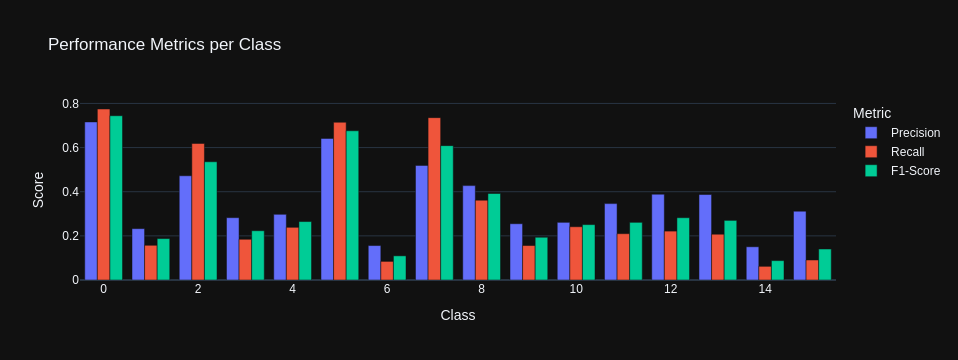

In [18]:
# Calculate performance metrics per class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_pred)

# Create a dataframe with the metrics
class_performance = pd.DataFrame({
    'Class': np.unique(test_labels),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Plot performance metrics per class
fig = px.bar(class_performance.melt(id_vars=['Class', 'Support'], 
                                    value_vars=['Precision', 'Recall', 'F1-Score']),
             x='Class', y='value', color='variable',
             barmode='group', title='Performance Metrics per Class',
             labels={'value': 'Score', 'variable': 'Metric'},
             hover_data=['Support'])
fig.show()


## Generate Predictions for test.txt using Node2Vec


In [8]:
# Load product IDs from test.txt
print("Loading product IDs from test.txt...")
test_txt_products = []
with open("test.txt", "r") as f:
    for line in f:
        t = line.split(',')
        test_txt_products.append(int(t[0]))

print(f"Loaded {len(test_txt_products)} product IDs from test.txt")

# Generate Node2Vec embeddings for test.txt products
print("Generating Node2Vec embeddings for test.txt products...")
test_txt_node2vec_features = np.zeros((len(test_txt_products), 64))

# Extract embeddings for test.txt products
for i, node_id in enumerate(test_txt_products):
    try:
        test_txt_node2vec_features[i] = n2v_model.wv[str(node_id)]
    except KeyError:
        # If node not in embeddings, use zeros
        pass

print(f"Node2Vec embeddings shape for test.txt products: {test_txt_node2vec_features.shape}")

# Scale the embeddings using the same scaler used for training
test_txt_node2vec_scaled = n2v_scaler.transform(test_txt_node2vec_features)

# Make predictions using the trained Node2Vec XGBoost model
print("Making predictions for test.txt products...")
test_txt_pred_proba = n2v_xgb_model.predict_proba(test_txt_node2vec_scaled)

# Create a DataFrame with the predictions
print("Creating CSV with predictions...")
predictions_df = pd.DataFrame()
predictions_df['product'] = test_txt_products

# Add probability columns for each class
for i in range(len(n2v_xgb_model.classes_)):
    predictions_df[f'class{i}'] = test_txt_pred_proba[:, i].round(4)

# Save predictions to CSV
predictions_df.to_csv('node2vec_predictions.csv', index=False)
print(f"Predictions saved to node2vec_predictions.csv")

# Display the first few rows of the predictions
print("\nSample of predictions:")
print(predictions_df.head())


Loading product IDs from test.txt...
Loaded 45502 product IDs from test.txt
Generating Node2Vec embeddings for test.txt products...
Node2Vec embeddings shape for test.txt products: (45502, 64)
Making predictions for test.txt products...
Creating CSV with predictions...
Predictions saved to node2vec_predictions.csv

Sample of predictions:
   product  class0  class1  class2  class3  class4  class5  class6  class7  \
0    49957  0.0042  0.0065  0.0131  0.0004  0.0033  0.0770  0.0159  0.0077   
1   135386  0.0033  0.0092  0.0242  0.0011  0.0094  0.0261  0.0058  0.0557   
2   226880  0.0008  0.0007  0.9911  0.0001  0.0042  0.0001  0.0002  0.0009   
3   165114  0.0008  0.0053  0.0142  0.0003  0.0051  0.0005  0.0025  0.0089   
4   256154  0.0010  0.0024  0.8493  0.0003  0.0008  0.0003  0.0007  0.0038   

   class8  class9  class10  class11  class12  class13  class14  class15  
0  0.0009  0.0005   0.8657   0.0010   0.0010   0.0014   0.0003   0.0010  
1  0.0043  0.8242   0.0208   0.0049   0.001